# HW2

**Author**: Ben Peloquin

**Collaborator**: Marc Harrison
    
**Date**: 20190507

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns
import sys
import tqdm

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)
print(module_path)
from psych253.cross_validation import get_splits, train_and_test_scikit_classifier
plt.style.use('ggplot')

%matplotlib inline

# Importing below so Chengxu doesn't have to scroll
# endlessly for version warnings...

import warnings
warnings.filterwarnings('ignore')

/Users/benpeloquin/Desktop/PHD/Classes/Psych253


# Setup

In [2]:
data_fp = "../data/ventral_neural_data.hdf5"
d_ventral = h5py.File(data_fp, 'r')
print(d_ventral.keys())

[u'image_meta', u'images', u'neural_meta', u'time_averaged', u'time_averaged_trial_averaged', u'time_binned', u'time_binned_trial_averaged']


In [3]:
chabo_mask = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Chabo'
tito_mask = d_ventral['neural_meta']['ANIMAL_INFO'][:] == 'Tito'

chabo_idxs = np.array(range(d_ventral['neural_meta']['ANIMAL_INFO'].shape[0]))[chabo_mask]
tito_idxs = np.array(range(d_ventral['neural_meta']['ANIMAL_INFO'].shape[0]))[tito_mask]

## Question 1: Regression in neural data

In [4]:
v4_idxs = d_ventral['neural_meta']['V4_NEURONS'][:]
it_idxs = d_ventral['neural_meta']['IT_NEURONS'][:]
print(d_ventral['image_meta'].keys())
d_all_sizes = d_ventral['image_meta']['size'][:]

[u'category', u'object_name', u'rotation_xy', u'rotation_xz', u'rotation_yz', u'size', u'translation_y', u'translation_z', u'variation_level']


In [5]:
# Features are neurons, prediction is size
X_v4 = d_ventral['time_averaged_trial_averaged'][:, v4_idxs[:-40]]  # Remove bad last 40
X_it = d_ventral['time_averaged_trial_averaged'][:, it_idxs]
datas = [('V4', X_v4), ('IT', X_it)]
y = d_all_sizes[:]
assert(map(lambda x: x[1].shape[0]==y.shape[0], datas))

### Question 1.1: Size regression from neural responses

#### 1.1.1.a OLS regression

In [6]:
def get_random_sample(X, size):
    """Helper for IT neurons"""
    sample_idxs = random.sample(range(X.shape[len(X.shape)-1]), k=size)
    return X[:, sample_idxs]

def get_split_idxs(total, train_prop=0.8, max_size=None):
    """Return train and test split of indices.
    
    Parameters
    ----------
    total: int
        Number indices.
    train_prob: float [Default: 0.8]
        Train size.
    max_size: int [Default: None]
        Limit max size (for sub-sampling)
    
    Returns
    -------
    tuple
        Train and test indices.

    """
    all_idxs = [i for i in range(total)]
    np.random.shuffle(all_idxs)
    if max_size is not None and max_size < total:
        all_idxs = all_idxs[:max_size]
    Xs = set(all_idxs[:int(len(all_idxs)*train_prop)])
    ys = set(all_idxs) - Xs
    return np.array(list(Xs)), np.array(list(ys))

def r_squared(predicted, actual):
    """The "rsquared" metric
    """
    a_mean = actual.mean()
    num = np.linalg.norm(actual - predicted)**2
    denom = np.linalg.norm(actual - a_mean)**2
    return 1 - num / denom

def run_model(model_klass, X_train, y_train, X_test, y_test, eval_fn=r_squared):
    """Run model helper.
    
    Parameters
    ----------
    model_klass: sklearn model object
        Sklearn model.
    X_train: np.array (num_examples, num_features)
        Train features.
    y_train: np.array (num_examples, )
        Train supervision.
    X_test: np.array (num_examples, num_features)
        Test features.
    y_test: np.array (num_examples, )
        Test supervision.
        
    Returns
    -------
    tuple
        Tuple of (float, float, sklearn object)
    
    """
    model = model_klass.fit(X_train, y_train)
    # Preds
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_preds = train_preds.squeeze()
    test_preds = test_preds.squeeze()
    train_loss = eval_fn(train_preds, y_train)
    test_loss = eval_fn(test_preds, y_test)
    return train_loss, test_loss, model

In [7]:
n_sims = 20
max_size = 88
train_prop = 0.8

In [8]:
d_results = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    # Note (BP): Here we sub-sample IT to have same 
    # size (88) as V4 with bad ones removed...
    X_it_partial = get_random_sample(X_it, size=max_size)
    datas.append(("IT_partial", X_it_partial))
    for roi, X in datas:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]

        # Fit model
        train_perf, test_perf, _ = \
            run_model(LinearRegression(), X_train, y_train, X_test, y_test)
        
        d_results.append({
            "sim_idx": sim_idx,
            "roi": roi,
            "train_r2": train_perf,
            "test_r2": test_perf
        })

df_results = pd.DataFrame(d_results)

100%|██████████| 20/20 [00:02<00:00,  4.17it/s]


In [9]:
df_results \
    .groupby(['roi'])['test_r2'] \
    .aggregate({np.mean, np.std}) \
    .reset_index()

,roi,mean,std
0,IT,0.357106,0.025140
1,IT_partial,0.308366,0.029272
2,V4,0.137107,0.023010


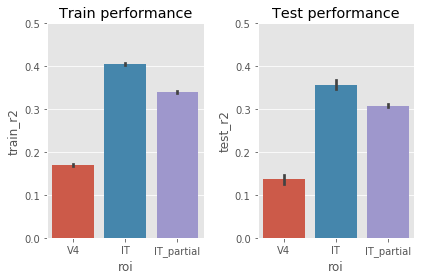

In [10]:
plt.subplot(121)
sns.barplot(x='roi', y='train_r2', ci=95, data=df_results)
plt.ylim(0, 0.5)
plt.title("Train performance")
plt.subplot(122)
sns.barplot(x='roi', y='test_r2', ci=95, data=df_results)
plt.ylim(0, 0.5)
plt.title("Test performance")
plt.tight_layout()

Let's run a t-test between the sub-sampled IT and V4

In [11]:
a = df_results[df_results['roi']=='V4'].test_r2
b = df_results[df_results['roi']=='IT_partial'].test_r2
ttest_ind(a, b)

Ttest_indResult(statistic=-25.409133115078856, pvalue=1.910183614495497e-68)

Comparing average $r^2$ between V4 and subsampled IT we see a significant difference (IT is higher).

#### 1.1.1.b  Ridge regression

In [12]:
n_sims = 30
max_size = 88
train_prop = 0.8
alphas = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]
models = [("ridge_{}".format(alpha), Ridge(alpha=alpha)) for alpha in alphas]
# Ordinary least squares
models.append(("ols", LinearRegression()))
# Ridge CV
models.append(("ridge_cv", RidgeCV(alphas=alphas)))

In [13]:
d_results = []
for sim_idx in tqdm.tqdm(range(n_sims)):
    train_idxs, test_idxs = current_indices = \
            get_split_idxs(len(y), train_prop)
    X_it_partial = get_random_sample(X_it, size=max_size)
    datas.append(("IT_partial", X_it_partial))
    for roi, X in datas:
        # Partition into train and test
        X_train = X[train_idxs, :]
        y_train = y[train_idxs]
        X_test = X[test_idxs, :]
        y_test = y[test_idxs]
        for model_nam, model in models:
            # Fit model
            train_perf, test_perf, _ = \
                run_model(model, X_train, y_train, X_test, y_test)

            d_results.append({
                "sim_idx": sim_idx,
                "model_name": model_nam,
                "roi": roi,
                "train_r2": train_perf,
                "test_r2": test_perf,
                "model_meta": model.alpha_ if model_nam == "ridge_cv" else None
            })

df_results = pd.DataFrame(d_results)

100%|██████████| 30/30 [01:32<00:00,  3.56s/it]


In [14]:
d_best = []
for roi, group in (df_results \
    .groupby(["model_name", "roi"])[["test_r2"]] \
    .aggregate({np.mean}) \
    .reset_index() \
    .groupby("roi")):
    best_idx = group['test_r2'].idxmax().values[0]
    r2 = group[group.index==best_idx].test_r2.values[0][0]
    model_name_ = group[group.index==best_idx].model_name.values[0]
    d_best.append({
        "roi": roi,
        "model": model_name_,
        "r2": r2
    })
df_best = pd.DataFrame(d_best)

In [15]:
df_best

,model,r2,roi
0,ridge_cv,0.365767,IT
1,ridge_10,0.307839,IT_partial
2,ridge_100,0.139437,V4


In [16]:
best_models = zip(df_best.roi.values, df_best.model.values)
best_models

[('IT', 'ridge_cv'), ('IT_partial', 'ridge_10'), ('V4', 'ridge_100')]

In [17]:
# Filter best models
df_bests = pd.concat(
    [df_results[(df_results.roi == roi) & (df_results.model_name==model)] for roi, model in best_models])

In [18]:
df_bests["best_model_for_roi"] = \
    df_bests.apply(lambda x: "{}_{}".format(x["roi"], x["model_name"]), axis=1)

Text(0.5,1,'Best model by ROI')

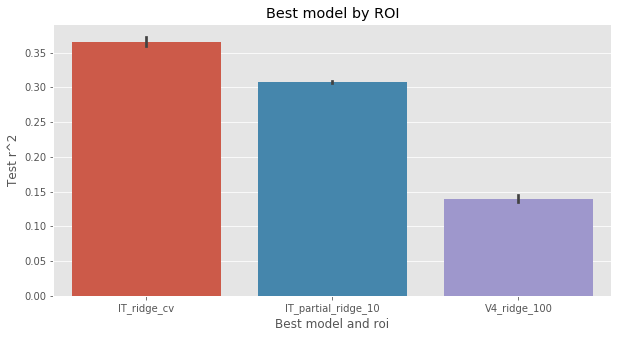

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(x="best_model_for_roi", y="test_r2", ci=95, data=df_bests)
plt.xlabel("Best model and roi")
plt.ylabel("Test r^2")
plt.title("Best model by ROI")

#### 1.1.1.c  Ridge regression with RidgeCV

Let's look at the alpha value found by RidgeCV in our runs above...

In [20]:
df_results[~df_results['model_meta'].isnull()] \
    .groupby(['roi', 'model_meta'])[['test_r2']] \
    .aggregate({np.mean, np.std, 'count'}) \
    .reset_index()[['roi', 'model_meta', 'test_r2']]

roi model_meta test_r2                    
                           count      mean       std
0          IT      100.0      30  0.365767  0.019080
1  IT_partial       10.0     968  0.307394  0.025963
2  IT_partial      100.0      97  0.310049  0.017779
3          V4       10.0       3  0.151821  0.022342
4          V4      100.0      27  0.137252  0.011455

Yes, we basically have the exact same outcome as explicitly running grid search over alpha values.

### Question 1.1.2: Predicting neural responses from neural responses

In [21]:
chabo_v4_idxs = set(v4_idxs) & set(chabo_idxs)
tito_v4_idxs = set(v4_idxs) & set(tito_idxs[:-40])

# Only good v4 from both animal
X_chabo_v4 = d_ventral['time_averaged_trial_averaged'][:, chabo_v4_idxs]
X_tito_v4 = d_ventral['time_averaged_trial_averaged'][:, tito_v4_idxs] 

Let's predict `tito` from `chabo`.

In [22]:
n_sims = 30
train_prob = 0.8
max_size = None
alphas = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]
n_components = [2**x for x in range(1, 7)]
models = [("ridge", RidgeCV(alphas=alphas)), ("lasso", LassoCV(alphas=alphas))]
pls_models = [("pls_{}".format(nc), PLSRegression(n_components=nc)) for nc in n_components]
models.extend(pls_models)

In [23]:
'alpha_' in dir(models[0][1])

False

In [24]:
n_sims = 30
train_prob = 0.8
max_size = None

def predict_one_neuron(neuron_idx, models, X_tito, X_chabo, 
                       n_sims=30, train_prop=0.8, max_size=None, verbose=True):
    """Predict a single neuron in tito from chabo activations.
    
    Parameters
    ----------
    neuron_idx: int
        Tito neuron index.
    models: list
        List of sklearn model objects (.fit() and .predict() methods)
    X_tito: np.array
        Tito dataset.
    X_chabo: np.array
        Chabo dataset.
    n_sims: int [Default: 30]
        Number of CV splits to run.
    train_prop: float [Default 0.8]
        CV train proportion.
    max_size: int [Default: None]
        Limit size of data in splits.
    
    Returns
    -------
    pd.DataFrame
        Dataframe.
    
    """
    y = X_tito[:, neuron_idx]
    X = X_chabo
    d = []
    for sim_idx in tqdm.tqdm(range(n_sims), disable=(not verbose)):
        train_idxs, test_idxs = current_indices = \
                get_split_idxs(len(y), train_prop, max_size)
        for model_name, model in models:
            # Partition into train and test
            X_train = X[train_idxs, :]
            y_train = y[train_idxs]
            X_test = X[test_idxs, :]
            y_test = y[test_idxs]
            train_perf, test_perf, model_ = \
                run_model(model, X_train, y_train, X_test, y_test)
            if model_name[:3] == 'pls':
                name = 'pls'
                hyperparam = model_name.split("_")[-1]
            elif 'alpha' in dir(model_):
                name = model_name
                hyperparam = model_.alpha
            elif 'alpha_' in dir(model_):
                name = model_name
                hyperparam = model_.alpha_
            else:
                raise Exception("Model is funky.")
                
            d.append({
                "sim_idx": sim_idx,
                "neuron_idx": neuron_idx,
                "model_name": name,
                "hyperparam": hyperparam,
                "train_r2": train_perf,
                "test_r2": test_perf
            })
    return pd.DataFrame(d)

In [25]:
all_dfs = []
for neuron_idx in tqdm.tqdm(range(X_tito_v4.shape[1])):
    all_dfs.append(predict_one_neuron(neuron_idx, models, X_tito_v4, X_chabo_v4, verbose=False))

100%|██████████| 18/18 [02:01<00:00,  6.75s/it]


In [26]:
df_chabo2tito = pd.concat(all_dfs)

We fit these models over *all* Tito neurons.

Let's first just aggregate over all the neurons.

In [27]:
df_chabo2tito \
    .groupby(["model_name", "hyperparam"])["test_r2"] \
    .aggregate({np.mean, np.std, "count"}) \
    .reset_index()

,model_name,hyperparam,count,mean,std
0,lasso,1e-05,49,0.468832,0.099335
1,lasso,0.001,455,0.398816,0.114575
2,lasso,0.01,36,0.186639,0.027318
3,pls,16,540,0.395205,0.119341
4,pls,2,540,0.343074,0.103566
5,pls,32,540,0.395193,0.119347
6,pls,4,540,0.386166,0.114410
7,pls,64,540,0.395193,0.119347
8,pls,8,540,0.394657,0.118748
9,ridge,10,179,0.505397,0.065682


We'll just define the best model settings as the `Lasso` and `Rdige` model that is most often selected (has highest count) and we'll do additional preprocessing for `pls`.

In [28]:
df_chabo2tito_agg = df_chabo2tito \
    .groupby(["model_name", "hyperparam"])["test_r2"] \
    .aggregate({np.mean, np.std, "count"}) \
    .reset_index()

In [29]:
def get_best_hyperparam(df, model):
    if model == "pls":
        best_idx = df \
            .query("model_name=='pls'".format(model))[['mean']] \
            .idxmax()
    else:
        best_idx = df \
            .query("model_name=='{}'".format(model))[['count']] \
            .idxmax()
        
    return df.iloc[best_idx]['hyperparam'].values[0]

best_hyperparams = \
    map(lambda x: (x, get_best_hyperparam(df_chabo2tito_agg, x)), 
        ['lasso', 'ridge', 'pls'])
best_hyperparams

[('lasso', 0.001), ('ridge', 100.0), ('pls', '16')]

In [30]:
filtr = \
    ((df_chabo2tito_agg['model_name'] == best_hyperparams[0][0]) & \
    (df_chabo2tito_agg['hyperparam'] == best_hyperparams[0][1])) | \
    ((df_chabo2tito_agg['model_name'] == best_hyperparams[1][0]) & \
    (df_chabo2tito_agg['hyperparam'] == best_hyperparams[1][1])) | \
    ((df_chabo2tito_agg['model_name'] == best_hyperparams[2][0]) & \
     (df_chabo2tito_agg['hyperparam'] == best_hyperparams[2][1]))
df_chabo2tito_agg[filtr]

,model_name,hyperparam,count,mean,std
1,lasso,0.001,455,0.398816,0.114575
3,pls,16,540,0.395205,0.119341
10,ridge,100,361,0.343510,0.099853


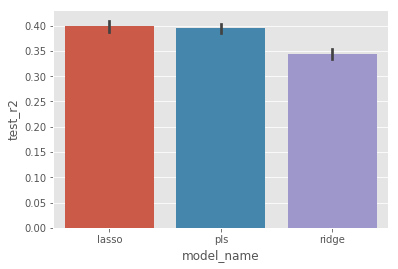

In [31]:
filtr = \
    ((df_chabo2tito['model_name'] == best_hyperparams[0][0]) & \
    (df_chabo2tito['hyperparam'] == best_hyperparams[0][1])) | \
    ((df_chabo2tito['model_name'] == best_hyperparams[1][0]) & \
    (df_chabo2tito['hyperparam'] == best_hyperparams[1][1])) | \
    ((df_chabo2tito['model_name'] == best_hyperparams[2][0]) & \
     (df_chabo2tito['hyperparam'] == best_hyperparams[2][1]))

sns.barplot(x='model_name', y='test_r2', data=df_chabo2tito[filtr])

* Lasso

The last time we ran this `1e-3` had the second highest mean value, but was most often found to have the best r^2 value. So we're going to set the best Lasso to `1e-3`.
* Ridge

Clearly it's `100` for Ridge.

* PLS

It's hard to differentiate for the various `n_components` as they're all quite close. If we just choose the argmax for r^2 we'd go with `n_components=16`.

In [32]:
best_ridge = Ridge(alpha=100)
best_lasso = Lasso(alpha=1e-3)
best_pls = PLSRegression(n_components=16)
models = [("ridge", best_ridge), ("lasso", best_lasso), ("pls_16", best_pls)]

In [33]:
all_dfs_best = []
for neuron_idx in tqdm.tqdm(range(X_tito_v4.shape[1])):
    all_dfs_best.append(predict_one_neuron(neuron_idx, models, X_tito_v4, X_chabo_v4, verbose=False))

100%|██████████| 18/18 [00:17<00:00,  1.06it/s]


In [34]:
df_bests = pd.concat(all_dfs_best)

In [35]:
df_bests.head()

,hyperparam,model_name,neuron_idx,sim_idx,test_r2,train_r2
0,100,ridge,0,0,0.406568,0.416948
1,0.001,lasso,0,0,0.400665,0.410492
2,16,pls,0,0,0.411029,0.423144
3,100,ridge,0,1,0.413701,0.417001
4,0.001,lasso,0,1,0.405264,0.410771


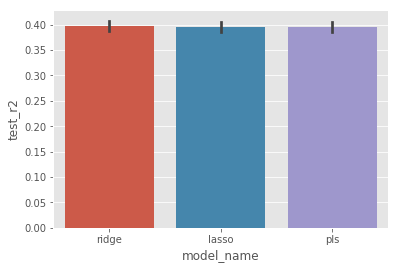

In [36]:
sns.barplot(x='model_name', y='test_r2', ci=95, data=df_bests)

In [37]:
df_bests \
    .groupby('model_name')[['test_r2']] \
    .aggregate({np.mean, np.std})

test_r2          
                mean       std
model_name                    
lasso       0.395105  0.121004
pls         0.395788  0.121294
ridge       0.397525  0.119751

Ridge appears to win out, but there really appear indistinguishable. Let's run a one-way anova to test for a significant difference between models...

In [38]:
f_oneway(df_bests[df_bests['model_name']=='lasso'].test_r2, 
         df_bests[df_bests['model_name']=='ridge'].test_r2,
         df_bests[df_bests['model_name']=='pls'].test_r2)

F_onewayResult(statistic=0.057715880052049626, pvalue=0.9439200397428302)

Doesn't appear to be a significant difference.

## Question 1.2: Regression in self-regulation ontology data

In [39]:
data_dir = "../data/self_regulation_data"
df_task_survey = pd.read_csv(os.path.join(data_dir, "task_survey_measures.csv"))
df_retest_task_survey = pd.read_csv(os.path.join(data_dir, "retest_task_survey_measures.csv"))
df_regulation = pd.read_csv(os.path.join(data_dir, "self_regulation_measures.csv"))
survey_cols = []
task_cols = []
for col in df_task_survey.columns[1:]:
    if "survey" in col:
        survey_cols.append(col)
    else:
        task_cols.append(col)        

Let's see how many subjects were retested

In [40]:
retested_subject_idxs = set(df_task_survey.subject_id) & set(df_retest_task_survey.subject_id)
n_retested = len(retested_subject_idxs)
total = len(set(df_task_survey.subject_id))
print("Original:\t{}".format(total))
print("Retested:\t{}".format(n_retested))
print("Prop:\t\t{}".format(round(float(n_retested) / total, 3)))

Original:	522
Retested:	150
Prop:		0.287


Ok so a little over a quarter were retested.

#### 1.2.2 Reliability of task and survey measures

In [41]:
# df_merged = df_task_survey.merge(df_retest_task_survey, 
#                                  on="subject_id", how='inner')
df_task_survey['type'] = 'test'
df_retest_task_survey['type'] = 'retest'
# Just look at shared measures
shared_cols = list(set(df_task_survey.columns) & set(df_retest_task_survey.columns))
df_task_survey_shared = df_task_survey[shared_cols]
df_retest_task_survey_shared = df_retest_task_survey[shared_cols]
# Restrict data to retested subjects
df_task_survey_shared = df_task_survey_shared[df_task_survey_shared['subject_id'].isin(retested_subject_idxs)]
df_retest_task_survey_shared = df_retest_task_survey_shared[df_retest_task_survey_shared['subject_id'].isin(retested_subject_idxs)]

assert df_task_survey_shared.shape == df_retest_task_survey_shared.shape
print("{} subjects under went retest on {} measures".format(*df_task_survey_shared.shape))

150 subjects under went retest on 166 measures


In [42]:
d_survey = []
valid_survey_cols = set(survey_cols) & set(shared_cols)
for survey_measure in valid_survey_cols:
    v1 = df_task_survey_shared[[survey_measure]].values.squeeze()
    v2 = df_retest_task_survey_shared[[survey_measure]].squeeze()
    d_survey.append({
        "type": "survey",
        "r2": r_squared(v1, v2),
        "measure": survey_measure
    })
df_survey_reliability = pd.DataFrame(d_survey)
    
d_task = []
valid_task_cols = set(task_cols) & set(shared_cols)
for task_measure in valid_task_cols:
    v1 = df_task_survey_shared[[task_measure]].values.squeeze()
    v2 = df_retest_task_survey_shared[[task_measure]].squeeze()
    d_task.append({
        "type": "task",
        "r2": r_squared(v1, v2),
        "measure": task_measure
    })
df_task_reliability = pd.DataFrame(d_task)

Text(0.5,0,'Counts')

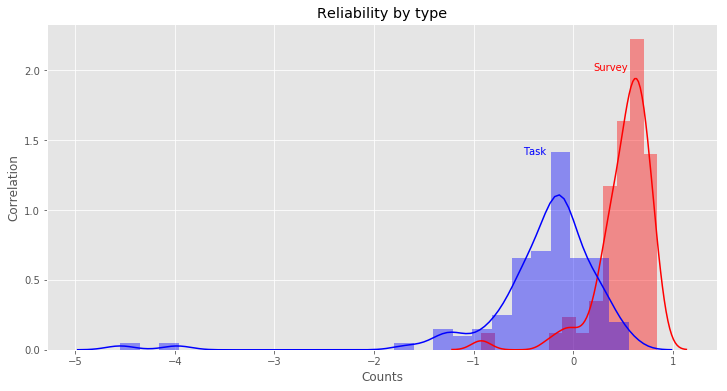

In [43]:
plt.figure(figsize=(12, 6))
sns.distplot(df_survey_reliability.r2, color='red')
plt.text(0.2, 2, "Survey", {'color': 'red'})
sns.distplot(df_task_reliability.r2, color='blue')
plt.text(-0.5, 1.4, "Task", {'color': 'blue'})
plt.title("Reliability by type")
plt.ylabel("Correlation")
plt.xlabel("Counts")

Interestingly, looks like survey data is *far* more reliable!

### 1.2.3 Problem 4: Regression to self regulation measures

Setup:

We are going to train seperate models for each regulation measure using original (not retest) data as our input features.

In [44]:
set(df_task_survey.subject_id) - set(df_regulation.subject_id)

set()

In [45]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

In [46]:
train_idxs, test_idxs = get_split_idxs(df_task_survey[task_cols].shape[0]);

In [47]:
df_features = df_task_survey[df_task_survey.columns[1:-1]] # remove first (subject_id) and last (type) cols
X_survey = np.asarray(df_features[survey_cols])
X_task = np.asarray(df_features[task_cols])
ys = {col: df_regulation[col].values for i, col in enumerate(df_regulation.columns[1:])}

In [48]:
d_results = []
X_train_survey = X_survey[train_idxs, :]
X_train_task = X_task[train_idxs, :]
X_test_survey = X_survey[test_idxs, :]
X_test_task = X_task[test_idxs, :]

for i, (reg_measure, y) in enumerate(ys.items()):
    # Note we set the random seed here so that we also take the same random split.
    # This is because we want the ys to vary, but not inputs
    y_train, y_test = y[train_idxs], y[test_idxs]
    
    for nam, trainer, tester in zip(
        ['survey', 'task'],
        [X_train_survey, X_train_task],
        [X_test_survey, X_test_task]):
        model = RidgeCV(alphas=alphas).fit(trainer, y_train)
        train_preds = model.predict(trainer)
        test_preds = model.predict(tester)
        train_performance = r_squared(train_preds, y_train)
        test_performance = r_squared(test_preds, y_test)
        d_results.append({
            "data": nam,
            "alpha": model.alpha_,
            "measure": reg_measure,
            "train_r2": train_performance,
            "test_r2": test_performance,
            "train_preds": train_preds,
            "test_preds": test_preds,
            "train_gold": y_train,
            "test_gold": y_test
        })
        
df_cols = ["data", "alpha", "measure", "train_r2", "test_r2"]
d_results2 = [{k: v for k, v in x.items() if k in df_cols} for x in d_results]
df_results = pd.DataFrame(d_results2)

Model performance
Blue=Survey
Red=Task


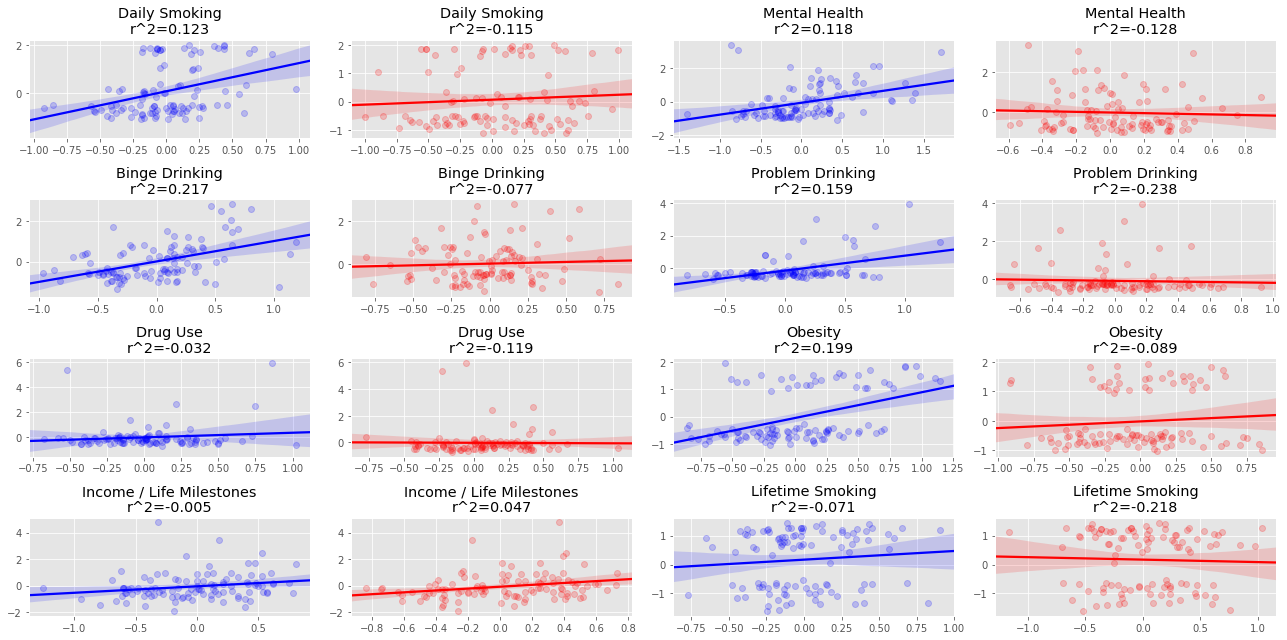

In [49]:
print("Model performance")
print("Blue=Survey")
print("Red=Task")
plt.figure(figsize=(18,9))
row_num = 0
col_num = 0
for i, x in enumerate(d_results2):
    plt.subplot(4, 4, i+1)
    col = "blue" if d_results[i]["data"] == "survey" else "red"
    sns.regplot(d_results[i]["test_preds"], 
                d_results[i]["test_gold"],
                scatter_kws={"alpha":0.2}, color=col)
    plt.title("{}\nr^2={}".format(d_results[i]["measure"], round(d_results[i]["test_r2"], 3)))
plt.tight_layout()

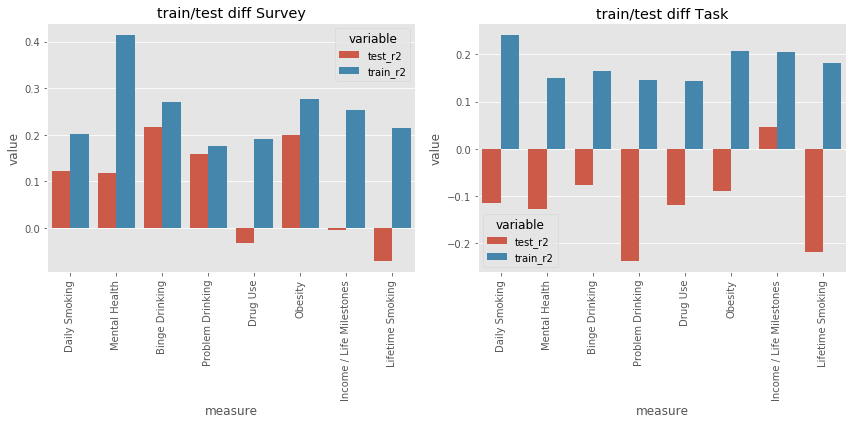

In [50]:
plt.figure(figsize=(12, 6))
df_results_melt = pd.melt(df_results, 
                          id_vars=["measure", "data"], 
                          value_vars=["test_r2", "train_r2"])
plt.subplot(121)
p = sns.barplot(x="measure", y="value", hue="variable", ci=None, 
                data=df_results_melt[df_results_melt["data"]=="survey"])
plt.xticks(rotation=90)
plt.title("train/test diff Survey")
plt.subplot(122)
p = sns.barplot(x="measure", y="value", hue="variable", ci=None, 
                data=df_results_melt[df_results_melt["data"]=="task"])
plt.xticks(rotation=90)
plt.title("train/test diff Task")
plt.tight_layout()

Note that in both cases we seem to be overfitting to train, however the problem is much, much worse with the `Task` data compared to `Survey`.